<a href="https://colab.research.google.com/github/anuliyan/Apple-Stock-Analysis-/blob/master/Amazon__Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

Predict whether a review is positive or negative based on the letter in the review.

In [0]:
#Install JAVA/Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [3]:
#Install pyspark
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 215.7MB 57kB/s 
     |████████████████████████████████| 204kB 50.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=34a790fd5469f26d3c7be58ce4606aafb1942e476d6f81d55394a2b43d0a901f
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# cleaning data, preparing a model,executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [5]:
#Mount G Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# linking the dataset

DATA_NAME = '/content/gdrive/My Drive/Colab Notebooks/COLAB DATASETS/reviews_Health_and_Personal_Care_5.json.gz'
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [0]:
#File Extraction
Health_and_Personal = sqlContext.read.json(DATA_NAME)

In [9]:
#Size of the dataset
print(f"Dataset shape is {Health_and_Personal.count():d} rows by {len(Health_and_Personal.columns):d} columns.")

Dataset shape is 346355 rows by 9 columns.


In [0]:
Health_and_Personal_test = Health_and_Personal.limit(100)

In [11]:
Health_and_Personal_test.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|159985130X|  [1, 1]|    5.0|This is a great l...| 01 5, 2011| ALC5GH8CAMAI7|                AnnN| Handy little gadget|    1294185600|
|159985130X|  [1, 1]|    4.0|I would recommend...|02 18, 2012| AHKSURW85PJUE| AZ buyer "AZ buyer"|Small & may need ...|    1329523200|
|159985130X|[75, 77]|    4.0|What I liked was ...| 06 8, 2010| A38RMU1Y5TDP9|Bob Tobias "Rober...|Very good but not...|    1275955200|
|159985130X|[56, 60]|    4.0|Love the Great po...| 02 8, 2008|A1XZUG7DFXXOS4|           Cat lover|great addition to...|    1202428800|
|159985130X|  [1, 1]|    5.0|This is very nice...|08 16

In [0]:
# If the overall is less than 3 it will be a negative review 
udf = UserDefinedFunction(lambda x: 1 if x > 2.0 else -1, IntegerType())


Health_and_Personal_test = Health_and_Personal_test.withColumn("overall_recode",udf(Health_and_Personal_test.overall))

([<matplotlib.axis.XTick at 0x7f478db0b8d0>,
 <a list of 2 Text xticklabel objects>)

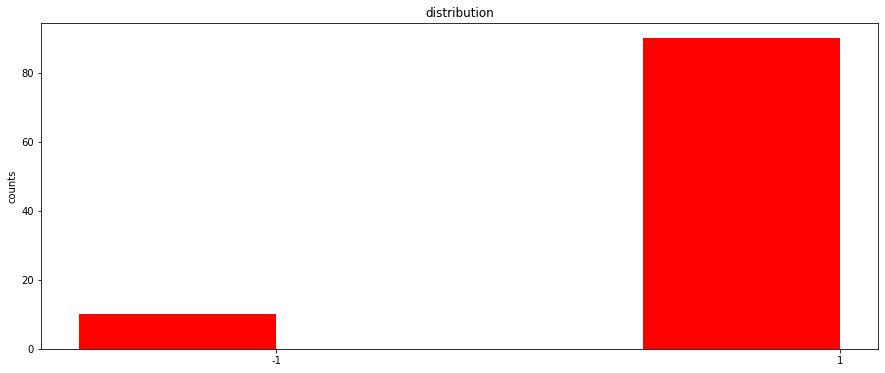

In [13]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = Health_and_Personal_test.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [14]:
Health_and_Personal_test.select("overall", "overall_recode").show(10)

+-------+--------------+
|overall|overall_recode|
+-------+--------------+
|    5.0|             1|
|    4.0|             1|
|    4.0|             1|
|    4.0|             1|
|    5.0|             1|
|    5.0|             1|
|    4.0|             1|
|    5.0|             1|
|    3.0|             1|
|    4.0|             1|
+-------+--------------+
only showing top 10 rows



In [0]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(Health_and_Personal_test)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [19]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|          w2v_vector|
+--------------+--------------------+--------------------+--------------------+
|             1|This is a great l...|[this, is, a, gre...|[-0.0063257018666...|
|             1|I would recommend...|[i, would, recomm...|[-0.0055632336493...|
|             1|What I liked was ...|[what, i, liked, ...|[-0.0056200885025...|
|             1|Love the Great po...|[love, the, great...|[-0.0055727143224...|
|             1|This is very nice...|[this, is, very, ...|[-0.0055186316552...|
|             1|The light comes o...|[the, light, come...|[-0.0071896280415...|
|             1|These are lightwe...|[these, are, ligh...|[-0.0051450958599...|
|             1|We bought one for...|[we, bought, one,...|[-0.0031569144406...|
|             1|The screen of the...|[the, screen, of,...|[-0.0059903999631...|
|             1|This pocket magni...|[th

In [0]:


# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [22]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.0714286
Accuracy = 0.928571
